In [1]:
import pandas as pd
pd.set_option('display.max_columns',50)
import numpy as np
import itertools as it
import json

import geopandas as gpd
import urllib.request

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as mtick

from scipy.stats import entropy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

%matplotlib inline

In [2]:
all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}

all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', "60": 'as',
                 "66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}

month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

regions_dict = {'Plains':['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
 'Rocky Mountains':['CO', 'ID', 'MT', 'UT', 'WY'],
 'Far West':['AK', 'CA', 'HI', 'NV', 'OR', 'WA'],
 'Southwest':['AZ', 'NM', 'OK', 'TX'],
 'Great Lakes':['IL', 'IN', 'MI', 'OH', 'WI'],
 'Southeast':['AL', 'AR', 'FL', 'GA', 'KY', 'LA', 'MS', 'NC', 'SC', 'TN', 'VA', 'WV'],
 'Other U.S. jurisdictions':['AS', 'GU', 'MP', 'PR', 'VI'],
 'New England':['CT', 'ME', 'MA', 'NH', 'RI', 'VT'],
 'Mid East':['DE', 'DC', 'MD', 'NJ', 'NY', 'PA']}
regions_dict_id = {i:[all_ids_state[x.lower()] for x in j] for i,j in regions_dict.items()}

reg_names = [[list(regions_dict_id.keys())[i]]*\
             len(list(regions_dict_id.values())[i]) for i in range(len(regions_dict))]
reg_state = list(regions_dict_id.values())

flat_names = [item for sublist in reg_names for item in sublist]
flat_state = [item for sublist in reg_state for item in sublist]
region_df = pd.DataFrame({'region':flat_names,
                          'state':[all_state_names[all_state_ids[i]] for i in flat_state]})

today = str(dt.datetime.date(dt.datetime.now()))

# make DATE_DF, a simple dataframe with dates, weekdays, and weeknums
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',
                   3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-01', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()
date_dict = dict(zip(DATERANGE,list(range(len(DATERANGE)))))

In [3]:
ihe_df    = pd.read_csv('../data/campus_covid_fall2020_full.csv', dtype={'ipeds_id':str, 'fips':str})
ipeds_df  = pd.read_csv('../data/campus_covid_ipeds.csv',          dtype={'ipeds_id':str, 'fips':str})
status_df = pd.read_csv('../data/campus_covid_status.csv',         dtype={'ipeds_id':str, 'fips':str})
census_df = pd.read_csv('../data/campus_covid_census.csv',         dtype={'fips':str})
jhu_df    = pd.read_csv('../data/campus_covid_jhu_county.csv.gz',  dtype={'fips':str})

ihe_df = ihe_df.merge(ipeds_df[['ipeds_id','fips','enrollment_fulltime',
                            'enrollment_total']], how='left', on='ipeds_id')

In [4]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../client_secret.json', scope)
client = gspread.authorize(creds)

In [5]:
ref_data = client.open("00_Reference")
ref_df = pd.DataFrame(ref_data.worksheet('reference').get_all_records(default_blank=np.nan))
cols = ['college','state','ipeds_id','status','data_url']
ref_df = ref_df[cols].copy()

In [6]:
ipeds_df = pd.read_csv('../data/ipeds_data.csv', encoding='latin8', dtype={'ipeds_id':str,
                                                       'Fips County code (HD2019)':str})

rename_ipeds = {'Institution Name':'name', 'Latitude location of institution (HD2019)':'lat',
                'Longitude location of institution (HD2019)':'lon', 'Level of Institution':'institution_level',
                'Control of institution':'institution_control', 'Institution Size':'institution_size_bin',
                'Total enrollment (DRVEF2018)':'enrollment_total','Fips County code (HD2019)':'fips',
                'Full-time enrollment (DRVEF2018)':'enrollment_fulltime', 
                'Endowment per FTE':'endowment_per_fte',
                'Percent admitted - total (DRVADM2019)':'percent_admitted'}

ipeds_df = ipeds_df.rename(columns=rename_ipeds)
ipeds_df = ipeds_df[['ipeds_id','fips', 'lat', 'lon', 'institution_level', 'institution_control',
                     'institution_size_bin', 'enrollment_total', 'enrollment_fulltime',
                     'endowment_per_fte', 'percent_admitted']]
ipeds_df['fips'] = ("0"+ipeds_df['fips'].str[:]).str[-5:]

complete_df = ref_df.loc[ref_df['status'].isin(['cumulative only','completed'])].copy()
incomple_df = ref_df.loc[~ref_df['status'].isin(['cumulative only','completed'])].copy()
complete_df['ipeds_id'] = complete_df['ipeds_id'].astype(str)
incomple_df['ipeds_id'] = incomple_df['ipeds_id'].astype(str)
complete_df = complete_df.merge(ipeds_df, how='left', on='ipeds_id')
incomple_df = incomple_df.merge(ipeds_df, how='left', on='ipeds_id')
complete_df = complete_df.merge(region_df, how='left', on='state')
incomple_df = incomple_df.merge(region_df, how='left', on='state')

In [7]:
map_projection_init = "epsg:4269"
map_projection = "epsg:2163"

drop_list = ["72","78","69","66","60","02","15"]

gdfcounty = gpd.read_file('../../covid19-mobility/data/tl_2017_us_county/')
gdfstate = gpd.read_file('../../covid19-mobility/data/tl_2017_us_state/')

gdfs = gdfstate.loc[~gdfstate['STATEFP'].isin(drop_list)].copy().reset_index().iloc[:,1:]
gdfc = gdfcounty.loc[~gdfcounty['STATEFP'].isin(drop_list)].copy().reset_index().iloc[:,1:]
gdfs_AL = gdfstate.loc[gdfstate['STATEFP']=='02'].copy().reset_index().iloc[:,1:]
gdfc_AL = gdfcounty.loc[gdfcounty['STATEFP']=='02'].copy().reset_index().iloc[:,1:]
gdfs_HI = gdfstate.loc[gdfstate['STATEFP']=='15'].copy().reset_index().iloc[:,1:]
gdfc_HI = gdfcounty.loc[gdfcounty['STATEFP']=='15'].copy().reset_index().iloc[:,1:]

gdfs.crs = {"init": map_projection_init}
gdfc.crs = {"init": map_projection_init}
gdfs_AL.crs = {"init": map_projection_init}
gdfc_AL.crs = {"init": map_projection_init}
gdfs_HI.crs = {"init": map_projection_init}
gdfc_HI.crs = {"init": map_projection_init}

gdfs = gdfs.to_crs({"init": map_projection})
gdfc = gdfc.to_crs({"init": map_projection})
gdfs_AL = gdfs_AL.to_crs({"init": map_projection})
gdfc_AL = gdfc_AL.to_crs({"init": map_projection})
gdfs_HI = gdfs_HI.to_crs({"init": map_projection})
gdfc_HI = gdfc_HI.to_crs({"init": map_projection})

In [8]:
geo_dfx = ipeds_df.loc[ipeds_df['ipeds_id'].isin(incomple_df['ipeds_id'].unique())][['ipeds_id','lat','lon']].copy()
geo_dfx = gpd.GeoDataFrame(geo_dfx,
                           geometry=gpd.points_from_xy(geo_dfx.lon, geo_dfx.lat))[['ipeds_id','geometry']]
geo_dfx = geo_dfx.reset_index().iloc[:,1:]
geo_dfx.crs = {"init": map_projection_init}
geo_dfx = geo_dfx.to_crs({"init": map_projection})

geo_dfx = geo_dfx.merge(ipeds_df[['ipeds_id','enrollment_fulltime']])
# geo_dfx = geo_dfx.merge(ipeds_df[['ipeds_id','enrollment_total']])

In [9]:
geo_df = ipeds_df.loc[ipeds_df['ipeds_id'].isin(complete_df['ipeds_id'].values)][['ipeds_id','lat','lon']].copy()
geo_df = gpd.GeoDataFrame(geo_df, geometry=gpd.points_from_xy(geo_df.lon, geo_df.lat))[['ipeds_id','geometry']]
geo_df = geo_df.reset_index().iloc[:,1:]
geo_df.crs = {"init": map_projection_init}
geo_df = geo_df.to_crs({"init": map_projection})

# geo_df = geo_df.merge(ipeds_df[['ipeds_id','enrollment_total']])
geo_df = geo_df.merge(ipeds_df[['ipeds_id','enrollment_fulltime']])

xx = geo_df.merge(complete_df[['ipeds_id','region']].drop_duplicates(),how='left',on='ipeds_id')
geo_dfx = geo_dfx.merge(incomple_df[['ipeds_id','region']].drop_duplicates(),how='left',on='ipeds_id')
xx.loc[xx.region.isna(),'region'] = 'na'
xx = xx.loc[xx['region']!='na'].copy()

region_summary = xx[['ipeds_id','region']].drop_duplicates().groupby('region').agg({'ipeds_id':'count'}).reset_index()
region_summary_dict = dict(zip(region_summary['region'].values, region_summary['ipeds_id'].values))
xx['region_label'] = [i+" (n=%i)"%(region_summary_dict[i]) if not pd.isna(i) else 'nan' for i in xx['region'].values]
xx = xx.loc[xx['region_label']!='nan'].copy()
geo_dfx['region_label'] = [i+" (n=%i)"%(region_summary_dict[i]) if not pd.isna(i) else 'nan' for i in geo_dfx['region'].values]
geo_dfx = geo_dfx.loc[geo_dfx['region_label']!='nan'].copy()

In [10]:
ihe_gdf = xx.merge(complete_df[['ipeds_id','state']].drop_duplicates(), how='left', on='ipeds_id')
ihe_gdfx = geo_dfx.merge(incomple_df[['ipeds_id','state']].drop_duplicates(), how='left', on='ipeds_id')

In [11]:
ihe_gdf_AL1 = ihe_gdf.loc[ihe_gdf['state']=='Alaska'].copy()
ihe_gdf_AL2 = ihe_gdfx.loc[ihe_gdfx['state']=='Alaska'].copy()
ihe_gdf_AL = pd.concat([ihe_gdf_AL1,ihe_gdf_AL2])
ihe_gdf_HI1 = ihe_gdf.loc[ihe_gdf['state']=='Hawaii'].copy()
ihe_gdf_HI2 = ihe_gdfx.loc[ihe_gdfx['state']=='Hawaii'].copy()
ihe_gdf_HI = pd.concat([ihe_gdf_HI1,ihe_gdf_HI2])

ihe_gdf = ihe_gdf.loc[~ihe_gdf['state'].isin(['Alaska','Hawaii'])].copy()
ihe_gdfx = ihe_gdfx.loc[~ihe_gdfx['state'].isin(['Alaska','Hawaii'])].copy()

hi_centroid = gdfs_HI['geometry'].centroid
al_centroid = gdfs_AL['geometry'].centroid
al_rotate = 24
hi_rotate = 24
gdfs_HI['geometry'] = gdfs_HI.rotate(hi_rotate, origin=hi_centroid[0])
gdfs_AL['geometry'] = gdfs_AL.rotate(al_rotate, origin=al_centroid[0])
gdfc_HI['geometry'] = gdfc_HI.rotate(hi_rotate, origin=hi_centroid[0])
gdfc_AL['geometry'] = gdfc_AL.rotate(al_rotate, origin=al_centroid[0])
ihe_gdf_HI['geometry'] = ihe_gdf_HI.rotate(hi_rotate, origin=hi_centroid[0])
ihe_gdf_AL['geometry'] = ihe_gdf_AL.rotate(al_rotate, origin=al_centroid[0])

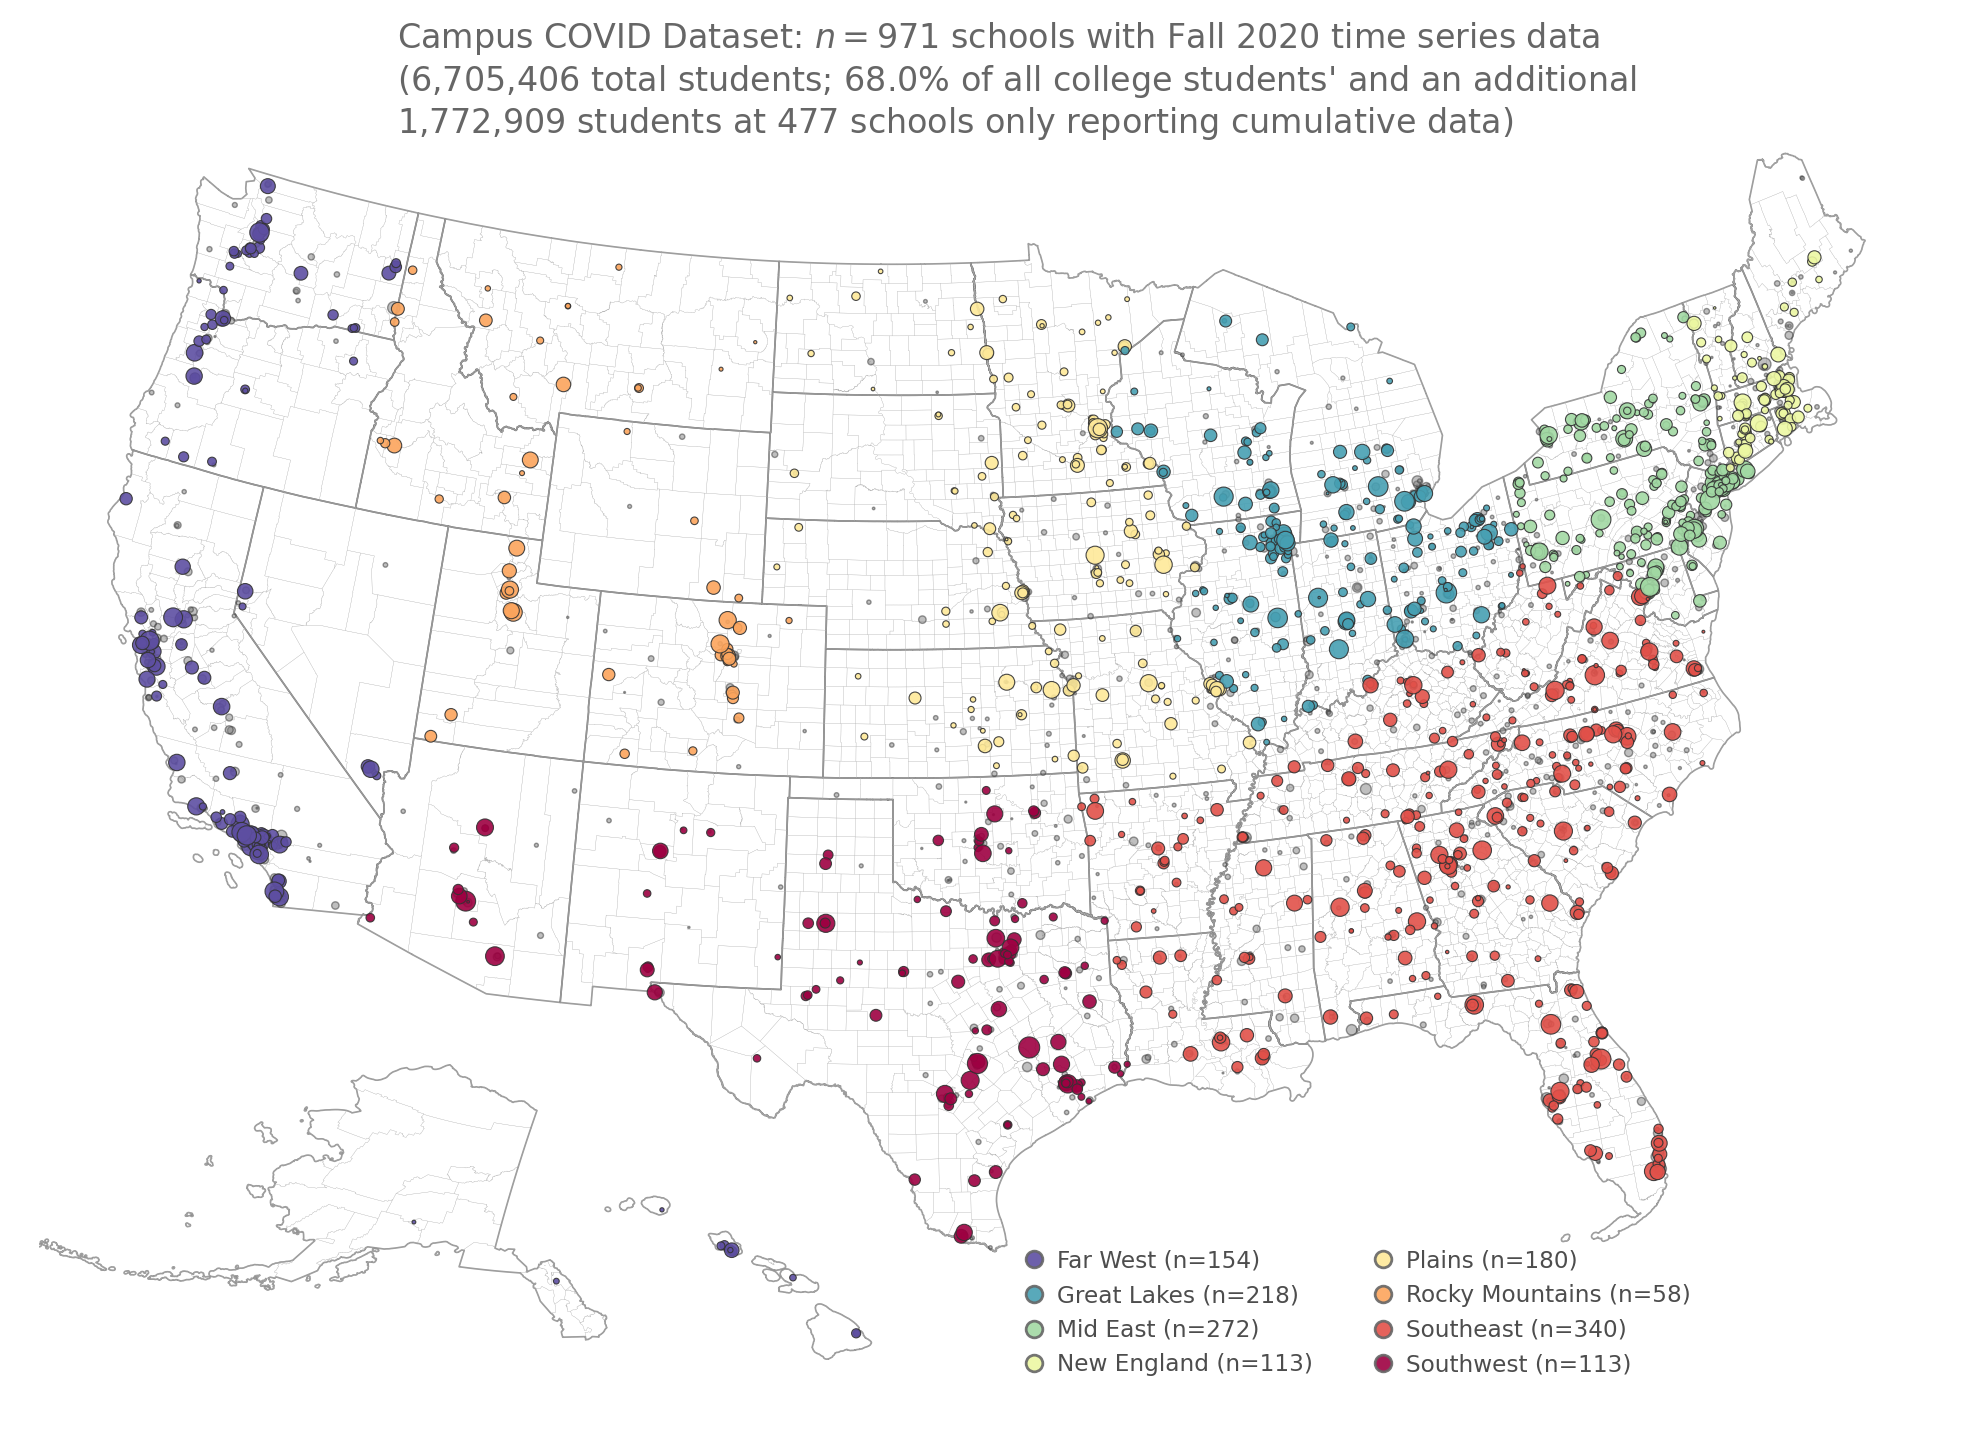

In [12]:
fig, ax = plt.subplots(1,1,figsize=(16,8),dpi=200)

gdfs.plot(ax=ax, lw=0.6, ec='.5', fc='none', alpha=0.8)
gdfc.plot(ax=ax, lw=0.1, ec='.7', fc='none', alpha=0.8)

al_ax = ax.inset_axes([0.01, -0.09, 0.30, 0.35], transform=ax.transAxes)
hi_ax = ax.inset_axes([0.25, -0.08, 0.20, 0.20], transform=ax.transAxes)

ihe_gdfx.plot(ax=ax,c='.5',lw=0.5,ec='.2',alpha=0.5,
            markersize=((np.log(ihe_gdfx['enrollment_fulltime'])**5)/7000)*1.25)


gdfs_AL.plot(ax=al_ax, lw=0.6, ec='.5', fc='none', alpha=0.8)
gdfc_AL.plot(ax=al_ax, lw=0.1, ec='.7', fc='none', alpha=0.8)
al_xmin, al_ymin, al_xmax, al_ymax = gdfs_AL.total_bounds
al_ydiff = al_ymax-al_ymin
al_xdiff = al_xmax-al_xmin
al_ax.set_ylim(al_ymin-al_ydiff*0.02, al_ymax+al_ydiff*0.01)
al_ax.set_xlim(al_xmin+al_xdiff*0.08, al_xmax+al_xdiff*0.02)

gdfs_HI.plot(ax=hi_ax, lw=0.6, ec='.5', fc='none', alpha=0.8)
gdfc_HI.plot(ax=hi_ax, lw=0.1, ec='.7', fc='none', alpha=0.8)
hi_xmin, hi_ymin, hi_xmax, hi_ymax = gdfs_HI.total_bounds
hi_ydiff = hi_ymax-hi_ymin
hi_xdiff = hi_xmax-hi_xmin
hi_ax.set_ylim(hi_ymin-hi_ydiff*0.02, hi_ymax-hi_ydiff*0.75)
hi_ax.set_xlim(hi_xmin+hi_xdiff*0.60, hi_xmax+hi_xdiff*0.02)

ms = 7
ms = markersize=((np.log(ihe_gdf['enrollment_fulltime'])**5)/7000)*2.5
ihe_gdf.plot(ax=ax, column='region_label', legend=True, markersize=ms,
             lw=0.4, ec='.2', alpha=0.9,
             cmap='Spectral_r', vmin=0, vmax=ihe_gdf.region.nunique()-1,
             legend_kwds={'ncol':2, 'fontsize':'small', 'framealpha':0, 'markerscale':0.6,
                          'loc':'lower right', 'bbox_to_anchor':[0.875, -0.075], 'handletextpad':0})
ms = markersize=((np.log(ihe_gdf_HI['enrollment_fulltime'])**5)/7000)*2.5
ihe_gdf_HI.plot(ax=hi_ax, column='region_label', markersize=ms, lw=0.4, ec='.2', alpha=0.9,
                cmap='Spectral_r', vmin=0, vmax=ihe_gdf.region.nunique()-1)
ms = markersize=((np.log(ihe_gdf_AL['enrollment_fulltime'])**5)/7000)*2.5
ihe_gdf_AL.plot(ax=al_ax, column='region_label', markersize=ms, lw=0.4, ec='.2', alpha=0.9,
                cmap='Spectral_r', vmin=0, vmax=ihe_gdf.region.nunique()-1)

leg = ax.get_legend()
for t in leg.get_texts():
    t.set_color('.3')
for l in leg.get_lines():
    l._legmarker.set_markeredgewidth(1.0)
    l._legmarker.set_markeredgecolor('.4')

ax.set_axis_off()
hi_ax.set_axis_off()
al_ax.set_axis_off()

percent_total_i = np.round(geo_df['enrollment_fulltime'].sum()/\
                           ipeds_df['enrollment_fulltime'].sum(),4)*100
ncomplete = complete_df.loc[complete_df['status']=='completed'].shape[0]
ncumul = complete_df.loc[complete_df['status']=='cumulative only'].shape[0]
popcomplete = int(complete_df.loc[complete_df['status']=='completed']['enrollment_fulltime'].sum())
popcumul = int(complete_df.loc[complete_df['status']=='cumulative only']['enrollment_fulltime'].sum())

ax.set_title("Campus COVID Dataset: $n=%s$ schools with Fall 2020 time series data"%("{:,}".format(ncomplete))+\
             "\n(%s total students; $%.1f$%% of all college students' and an additional"%(
                    "{:,}".format(popcomplete),
                    percent_total_i)+\
         "\n%s students at $%i$ schools only reporting cumulative data)"%("{:,}".format(popcumul),
                                                                                        ncumul),
             x=0.195, y=0.95, va='bottom', ha='left', color='.4')


# plt.savefig('../figs/pngs/campus_covid_map.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/campus_covid_map.pdf',dpi=425,bbox_inches='tight')

plt.show()